In [991]:
import warnings
warnings.simplefilter(action='ignore')

In [1592]:
# from imblearn.over_sampling

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from scipy.stats.mstats import winsorize  # nan_policy does not work
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier

from supporting_funcs import *
import pickle
import os

In [1555]:
fname = './data/data.csv'
df = pd.read_csv(fname)
df.drop(['Loan_ID'], axis=1, inplace=True)

In [1556]:
# SETTING CLASS WEIGHTS
# wj=n_samples / (n_classes * n_samplesj)
# wj is the weight for each class(j signifies the class)
n_samples = df.shape[0]                             # n_samples is the total number of samples or rows in the dataset
n_classes = 2                                       # n_classes is the total number of unique classes in the target
n_sample1 = df[df['Loan_Status'] == 'Y'].shape[0]     # n_samplesj is the total number of rows of the respective class
n_sample2 = df[df['Loan_Status'] == 'N'].shape[0]

In [1557]:
weight1 = n_samples / (n_classes * n_sample1)
weight2 = n_samples / (n_classes * n_sample2)

### Modeling

### First Approach

In [1558]:
cat_feats = df.columns[df.dtypes == 'object'].tolist()  # categorical features
num_feats = df.columns[df.dtypes != 'object'].tolist()  # numeric features

In [1559]:
# turning 0 to np.nan
df['CoapplicantIncome'] = np.where(df['CoapplicantIncome'] == 0, np.nan, df['CoapplicantIncome'])

In [1560]:
# saving indices of nan for categorical values that will be inserted back in place after applying get_dummies
na_indices = {cat: df[df[cat].isna()].index.tolist() for cat in cat_feats}

In [1561]:
# applying get dummies to cat features (NOTE: get_dummies() turns nan into 0)
dummies = pd.get_dummies(df[cat_feats])

In [1562]:
# creating dictionary where key is cat features & value is a list with newly created dummies corresponding to old feature
dm_cols = dummies.columns[dummies.dtypes != 'object'].tolist()
dm_map = {}
for feat in cat_feats:
    dm_map[feat] = []
    for col in dm_cols:
        if col.startswith(feat):
            dm_map[feat].append(col)

In [1563]:
# inserting nan back into their positions (nan will be inserted into each category of initial column)
for feat, col_names in dm_map.items():
    for col_name in col_names:
        dummies[col_name].iloc[na_indices[feat]] = np.nan

In [1564]:
# concatenating numeric features with dummies
df = pd.concat([df[num_feats], dummies], axis=1)

In [1565]:
# initializing knn imputer
knn = KNNImputer(n_neighbors=3)
df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)

In [1566]:
# winsorizing following columns. NOTE: scipy.stats.mstats.winsorize doesn't preserve nan, therefore custom func is applied

# sns.swarmplot(data=df, x='CoapplicantIncome')
# plt.show()
# sns.swarmplot(data=df, x='ApplicantIncome')
# plt.show()
df['ApplicantIncome'] = winsorize_pandas(df['ApplicantIncome'], limits=(0, 0.1))
df['CoapplicantIncome'] = winsorize_pandas(df['CoapplicantIncome'], limits=(0, 0.1))
# sns.swarmplot(data=df, x='CoapplicantIncome')
# plt.show()
# sns.swarmplot(data=df, x='ApplicantIncome')
#############################################
# sns.swarmplot(data=df, x='LoanAmount')
# plt.show()
df['LoanAmount'] = winsorize_pandas(df['LoanAmount'], limits=(0, 0.05))
# sns.swarmplot(data=df, x='LoanAmount')v

In [1567]:
df['CombinedIncome'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df['LoanAmount'] = np.log(df['LoanAmount'])
df['loan/income_ration'] = (df['LoanAmount'] / df['CombinedIncome'] )
df['Loan_Amount_Term'] = df['Loan_Amount_Term'] / 12

In [1569]:
# sns.scatterplot(data=df, x='CombinedIncome', y='loan/income_ration')

In [1571]:
# sns.histplot(data=df, x='loan/income_ration')

In [1572]:
df.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

In [1573]:
y = df['Loan_Status_Y']
df = df.drop(['Loan_Status_Y', 'Loan_Status_N'], axis=1)

In [1574]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4, stratify=y, train_size=0.7)

<BarContainer object of 20 artists>

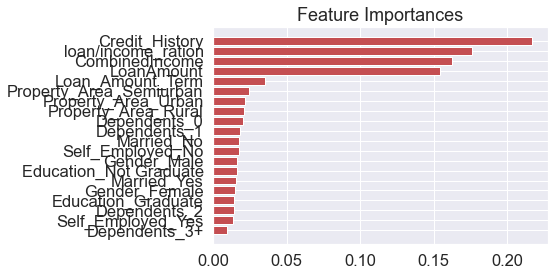

In [1581]:
rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(X_train.columns[indices], importances[indices], color='r')

In [1582]:
params = [
    {
        'C': [0.06, 0.07, 0.09],
        'class_weight': [{0:x, 1:1-x} for x in np.linspace(0.2, 0.8, 150)],
        'intercept_scaling': [0.1],
        'max_iter': [10000],
        'penalty': ['l1'],
        'solver': ['newton-cg', 'liblinear', 'saga'],

    }
]
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=params,
                           cv=StratifiedKFold(shuffle=True, n_splits=10), scoring='f1', verbose=0, n_jobs=-1)

In [1583]:
grid_search.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [1584]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.06, 0.07, 0.09],
                          'class_weight': [{0: 0.2, 1: 0.8},
                                           {0: 0.20402684563758391,
                                            1: 0.7959731543624161},
                                           {0: 0.2080536912751678,
                                            1: 0.7919463087248322},
                                           {0: 0.2120805369127517,
                                            1: 0.7879194630872484},
                                           {0: 0.21610738255033557,
                                            1: 0.783892617...
                                            1: 0.7033557046979866},
                                           {0: 0.30067114093959735,
                                            1: 0.6993288590604027},
             

In [1585]:
grid_search.best_params_

{'C': 0.09,
 'class_weight': {0: 0.6107382550335572, 1: 0.38926174496644284},
 'intercept_scaling': 0.1,
 'max_iter': 10000,
 'penalty': 'l1',
 'solver': 'saga'}

In [1586]:
print('Train Data f1', metrics.f1_score(y_train, grid_search.predict(X_train)))
print('Test Data f1', metrics.f1_score(y_test, grid_search.predict(X_test)))

Train Data f1 0.8683812405446293
Test Data f1 0.8928571428571429


In [1587]:
print(metrics.classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.52      0.67        58
         1.0       0.82      0.98      0.89       127

    accuracy                           0.84       185
   macro avg       0.88      0.75      0.78       185
weighted avg       0.85      0.84      0.82       185



In [1588]:
# grid_search.predict_proba(X_test)

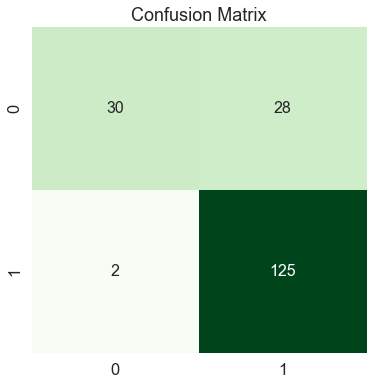

In [1589]:
conf_matrix(metrics.confusion_matrix(y_test, grid_search.predict(X_test)))

# Second Approach

In [1519]:
df = pd.read_csv(fname)
df = df.drop(['Loan_ID'], axis=1)

In [1520]:
y = df['Loan_Status']
df = df.drop(['Loan_Status',], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4, stratify=y, train_size=0.7)

In [1521]:
lbl_enc = LabelEncoder()
y_test = lbl_enc.fit_transform(y_test)
y_train = lbl_enc.fit_transform(y_train)

In [1522]:
def pipe(df_):
    df_ = pd.get_dummies(df_, drop_first=True)
    imputed = KNNImputer(n_neighbors=3)
    dft_impu = imputed.fit_transform(df_)
    df_ = pd.DataFrame(dft_impu, columns=df_.columns.tolist())
    df_['LoanAmount'] = np.log(df_['LoanAmount'])
    df_['Combined_Income'] = df_['ApplicantIncome'] + df_['CoapplicantIncome']
    df_['Combined_Income'] = np.log(df_['Combined_Income'])
    df_['loan/income_ration'] = (df_['LoanAmount'] / df_['Combined_Income'] ) * 100
    df_ = df_.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1)
    df_['Loan_Amount_Term'] = df_['Loan_Amount_Term'] / 12
    return df_

In [1523]:
X_train = pipe(X_train)
X_test = pipe(X_test)

In [1628]:
params = [
    {
        'loss': ['deviance'],
        'n_estimators': [100],
        'min_samples_leaf': [0.1],
        'min_samples_split': [0.1, 1, 2],
        'max_depth': [9, 10, 11],
        'max_features': [8, 9, 10],
        'learning_rate': np.linspace(0.01, 0.5, 5)
    }
]

In [1629]:
gradboost_grid = GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1, param_grid=params,
                              cv=StratifiedKFold(shuffle=True, n_splits=10), scoring='f1')

In [1630]:
gradboost_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ]),
                          'loss': ['deviance'], 'max_depth': [9, 10, 11],
                          'max_features': [8, 9, 10], 'min_samples_leaf': [0.1],
                          'min_samples_split': [0.1, 1, 2],
                          'n_estimators': [100]}],
             scoring='f1')

In [1631]:
gradboost_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 0.1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [1633]:
gradboost_grid.score(X_train, y_train)

0.863568215892054

In [1634]:
gradboost_grid.score(X_test, y_test)

0.8771929824561403

In [1635]:
# gradboost_grid.estimator.get_params().items()

In [1524]:
params = [
    {
        'C': [0.07, 0.08, 0.09, 0.1],
        'class_weight': [{0:x, 1:1-x} for x in np.linspace(0.2, 0.8, 100)],
        'intercept_scaling': [0.1],
        'max_iter': [100],
        'penalty': ['l1'],
        'solver': ['newton-cg', 'liblinear'],
    }
]
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=params,
                           cv=StratifiedKFold(shuffle=True, n_splits=10), scoring='f1', verbose=0, n_jobs=-1)

In [1525]:
grid_search.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [1526]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.07, 0.08, 0.09, 0.1],
                          'class_weight': [{0: 0.2, 1: 0.8},
                                           {0: 0.20606060606060608,
                                            1: 0.793939393939394},
                                           {0: 0.21212121212121213,
                                            1: 0.7878787878787878},
                                           {0: 0.2181818181818182,
                                            1: 0.7818181818181817},
                                           {0: 0.22424242424242424,
                                            1: 0.77575...
                                            1: 0.6545454545454545},
                                           {0: 0.35151515151515156,
                                            1: 0.6484848484848484},
            

In [1527]:
grid_search.best_params_

{'C': 0.08,
 'class_weight': {0: 0.6121212121212122, 1: 0.3878787878787878},
 'intercept_scaling': 0.1,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [1528]:
pred_test = grid_search.predict(X_test)
probas_test = pd.Series(grid_search.predict_proba(X_test)[:, 1])
adj_prob_test = np.where(probas_test <= 0.61, 0, 1)

pred_train = grid_search.predict(X_train)
probas_train = pd.Series(grid_search.predict_proba(X_train)[:, 1])
adj_prob_train = np.where(probas_train <= 0.61, 0, 1)

In [1529]:
print('Train')
print('F1 Score is :', grid_search.score(X_train, y_train))
print(f"Adjusted Proba F1 Score is : {metrics.f1_score(y_train, adj_prob_train)}")
print('\nTest')
print('F1 Score is :', grid_search.score(X_test, y_test))
print(f"Adjusted Proba F1 Score is : {metrics.f1_score(y_test, adj_prob_test)}")

Train
F1 Score is : 0.8623298033282905
Adjusted Proba F1 Score is : 0.8499210110584519

Test
F1 Score is : 0.8975265017667845
Adjusted Proba F1 Score is : 0.8905109489051095


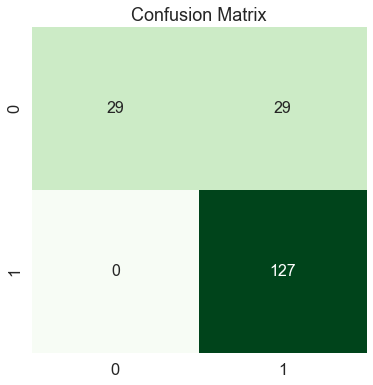

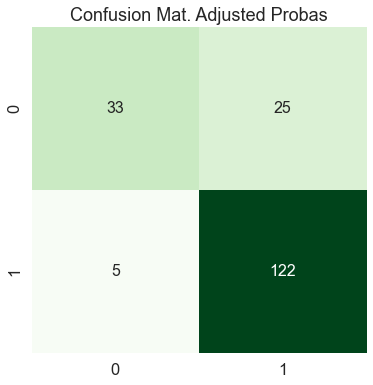

In [1530]:
conf_matrix(metrics.confusion_matrix(y_test, pred_test))
conf_matrix(metrics.confusion_matrix(y_test, adj_prob_test), title='Confusion Mat. Adjusted Probas')

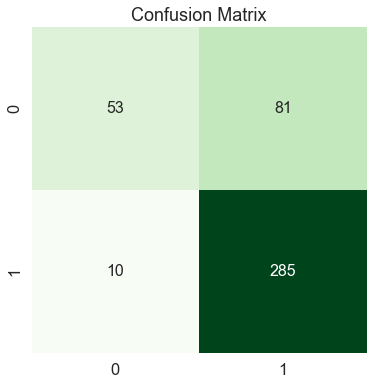

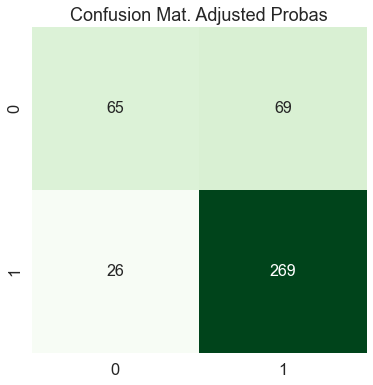

In [1531]:
conf_matrix(metrics.confusion_matrix(y_train, pred_train))
conf_matrix(metrics.confusion_matrix(y_train, adj_prob_train), title='Confusion Mat. Adjusted Probas')

<BarContainer object of 14 artists>

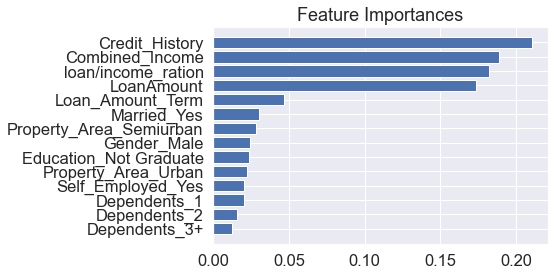

In [1532]:
rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(X_train.columns[indices], importances[indices], color='b', align='center')

<AxesSubplot:>

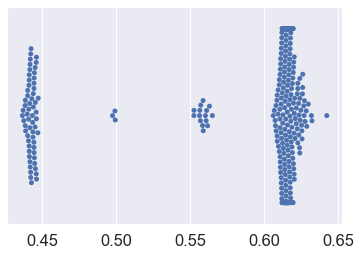

In [1534]:
sns.swarmplot(probas_train)

<AxesSubplot:>

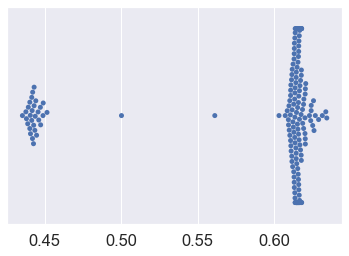

In [1536]:
sns.swarmplot(probas_test)